In [180]:
import time
import warnings

import torch
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.double

from botorch.test_functions import Ackley
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
from botorch.optim import optimize_acqf


from botorch import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.acquisition.analytic import LogExpectedImprovement
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.exceptions.warnings import NumericsWarning
from botorch.sampling.normal import SobolQMCNormalSampler

warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=NumericsWarning)

import matplotlib.pyplot as plt
%matplotlib inline

In [181]:
SMOKE_TEST = False

# objective parameters
DIM = 6
LB = -5.0
UB = 5.0
BOUNDS = torch.tensor([[LB] * DIM, [UB] * DIM], device=device, dtype=dtype)

# params for acqf optimization
BATCH_SIZE = 1    #must be 1 for analytic acqf
NUM_RESTARTS = 10 if not SMOKE_TEST else 2    # number of restarts to find optimized acqf
RAW_SAMPLES = 512 if not SMOKE_TEST else 32    # X samples for the start of local optimization of acqf
MC_SAMPLES = 256 if not SMOKE_TEST else 32    # MC samples for posterior distribution estimation

# optim run params
N_TRIALS = 5 if not SMOKE_TEST else 2
N_BATCH = 30 if not SMOKE_TEST else 2

torch.manual_seed(0)

In [182]:
neg_ackley = Ackley(dim=DIM, negate=True)

if DIM == 1:    # plot
    x = torch.tensor(np.linspace(LB, UB, 1000), dtype=dtype).unsqueeze(-1)
    y = neg_ackley(x)
    plt.plot(x, y)

In [183]:
def generate_initial_data(n=10):
    # generate training data
    train_x = torch.rand(10, DIM, device=device, dtype=dtype)
    train_obj = neg_ackley(train_x).unsqueeze(-1)  # add output dimension
    best_observed_value = train_obj.max().item()
    return train_x, train_obj, best_observed_value


def initialize_model(train_x, train_obj, state_dict=None):
    # define models for objective and constraint
    model = SingleTaskGP(
        train_x, 
        train_obj,
        outcome_transform=Standardize(train_obj.shape[-1]),
        input_transform=Normalize(train_x.shape[-1])
        ).to(train_x)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    # load state dict if it is passed
    if state_dict is not None:
        model.load_state_dict(state_dict)
    return mll, model

In [184]:
def optimize_acqf_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation."""
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=BOUNDS,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )
    # observe new values
    new_x = candidates.detach()
    new_obj = neg_ackley(new_x).unsqueeze(-1)  # add output dimension
    return new_x, new_obj


def update_random_observations(best_random):
    """Simulates a random policy by taking a the current list of best values observed randomly,
    drawing a new random point, observing its value, and updating the list.
    """
    rand_x = torch.rand(BATCH_SIZE, DIM)
    next_random_best = neg_ackley(rand_x).max().item()
    best_random.append(max(best_random[-1], next_random_best))
    return best_random

In [185]:
verbose = False

best_observed_all_ei,  best_random_all = [], []


# average over multiple trials
for trial in range(1, N_TRIALS + 1):

    print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
    best_observed_ei, best_random = [], []

    # call helper functions to generate initial training data and initialize model
    train_x_ei, train_obj_ei, best_observed_value_ei = generate_initial_data(n=10)
    mll_ei, model_ei = initialize_model(train_x_ei, train_obj_ei)

    best_observed_ei.append(best_observed_value_ei)
    best_random.append(best_observed_value_ei)

    # run N_BATCH rounds of BayesOpt after the initial random batch
    for iteration in range(1, N_BATCH + 1):

        t0 = time.monotonic()

        # fit the models
        fit_gpytorch_mll(mll_ei)

        # define the qEI and qNEI acquisition modules using a QMC sampler
        qmc_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

        # for best_f, we use the best observed noisy values as an approximation
        qEI = LogExpectedImprovement(
            model=model_ei,
            best_f=train_obj_ei.max()
        )

        # optimize and get new observation
        new_x_ei, new_obj_ei = optimize_acqf_and_get_observation(qEI)

        # update training points
        train_x_ei = torch.cat([train_x_ei, new_x_ei])
        train_obj_ei = torch.cat([train_obj_ei, new_obj_ei])

        # update progress
        best_random = update_random_observations(best_random)
        best_value_ei = neg_ackley(train_x_ei).max().item()
        best_observed_ei.append(best_value_ei)

        # reinitialize the models so they are ready for fitting on next iteration
        # use the current state dict to speed up fitting
        mll_ei, model_ei = initialize_model(
            train_x_ei,
            train_obj_ei,
            model_ei.state_dict(),
        )

        t1 = time.monotonic()

        if verbose:
            print(
                f"\nBatch {iteration:>2}: best_value (random, qEI) = "
                f"({max(best_random):>4.2f}, {best_value_ei:>4.2f}), "
                f"time = {t1-t0:>4.2f}.",
                end="",
            )
        else:
            print(".", end="")

    best_observed_all_ei.append(best_observed_ei)
    best_random_all.append(best_random)


Trial  1 of 5 ..............................
Trial  2 of 5 ..............................
Trial  3 of 5 ..............................
Trial  4 of 5 ..............................
Trial  5 of 5 ..............................

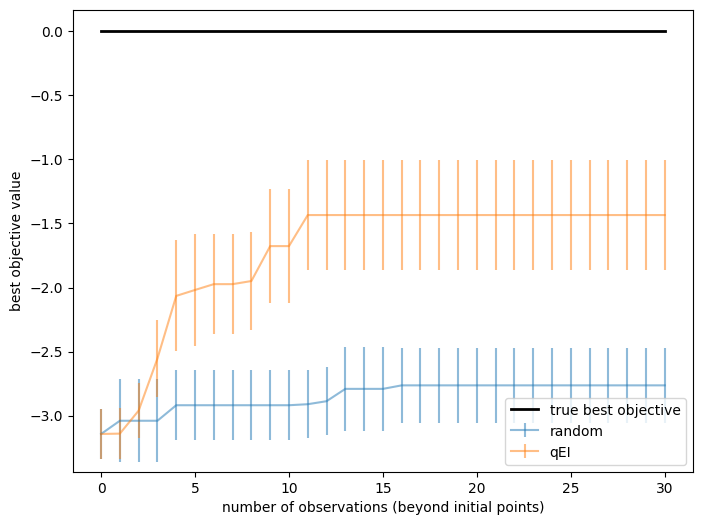

In [186]:
def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)


GLOBAL_MAXIMUM = neg_ackley.optimal_value


iters = np.arange(N_BATCH + 1) * BATCH_SIZE
y_ei = np.asarray(best_observed_all_ei)
y_rnd = np.asarray(best_random_all)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(iters, y_rnd.mean(axis=0), yerr=ci(y_rnd), label="random", linewidth=1.5, alpha=0.5)
ax.errorbar(iters, y_ei.mean(axis=0), yerr=ci(y_ei), label="qEI", linewidth=1.5, alpha=0.5)
plt.plot(
    [0, N_BATCH * BATCH_SIZE],
    [GLOBAL_MAXIMUM] * 2,
    "k",
    label="true best objective",
    linewidth=2,
)
ax.set_ylim(np.min([y_ei.min(), y_rnd.min()]))
ax.set(
    xlabel="number of observations (beyond initial points)",
    ylabel="best objective value",
)
ax.legend(loc="lower right")